In [1]:
%load_ext autoreload 
%autoreload 2 

In [3]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # for subplots
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
# import tensorflow as tf

from src.utilities.plot_helpers import generate_random_colors
# from src.modeling.experiments.binned_trial_experiment_01 import split_data

from src.utilities.pandas_helpers import get_features
plt.rcdefaults()

## Experimental conditions: 
* 2 layer LSTM 
* trained with 128 units
* control data is full dataset
* experimental data is full dataset without binned trials

#### Load Model

In [ ]:
# directory paths
DATA_PATH = '/projects/p31961/gaby_data/aggregated_data/data_pipeline_full_dataset/datasets/full_dataset.parquet.gzip'
PATH_TO_MODELS = '/projects/p31961/ENIGMA/results/experiments/binned_trial_experiment_01/models'
control_path = os.path.join(PATH_TO_MODELS, 'control')
no_bins_path = os.path.join(PATH_TO_MODELS, 'dropped_binned_trials')


In [ ]:

control_model = tf.keras.models.load_model(control_path)
dropped_bins_model = tf.keras.models.load_model(no_bins_path)
control_model.compile(optimizer='adam', loss='mse', metrics=[
                  'mae', 'mse', 'mape', 'cosine_similarity'])
dropped_bins_model.compile(optimizer='adam', loss='mse', metrics=[
                  'mae', 'mse', 'mape', 'cosine_similarity'])


models = [control_model, dropped_bins_model]

# Model Summary

In [ ]:
for model in models:
    print(model.summary())

#### load training and testing data

In [ ]:
data= pd.read_parquet(DATA_PATH)
data.head()

In [ ]:
# split data for control
target='signal'
control_features = get_features(data, target)
no_bin_features = control_features.copy()
no_bin_features.remove('learning_phase')

X_train, y_train, X_val, y_val, X_test, y_test = split_data(data, control_features, target, day_cut_off=6, feature_to_drop=None)

    # split data for dropped binned trials
X_train_dropped, y_train_dropped, X_val_dropped, y_val_dropped, X_test_dropped, y_test_dropped = split_data(
data, no_bin_features, target, day_cut_off=6, feature_to_drop='learning_phase')

In [ ]:
y_control_pred = control_model.predict(X_test)
y_dropped_pred = dropped_bins_model.predict(X_test_dropped)

# Full dataset

## Validation check

In [ ]:
data_directory = os.path.dirname(DATA_PATH)

### control dataset with inference

In [ ]:
control_inference_data= X_test.assign(predicted_signal= y_control_pred,
                                              true_signal=y_test)
control_inference_data.to_parquet(os.path.join(data_directory, 'control_inference_data.parquet.gzip'), compression='gzip')

In [ ]:
control_inference_data.head()

In [ ]:
#load data if previously saved
control_inference_data = pd.read_parquet(os.path.join(data_directory, 'control_inference_data.parquet.gzip'))


In [4]:
interm_path = '/Users/michaelschaid/Desktop/interm_data_transfer/control_inference_data.parquet.gzip'
control_inference_data = pd.read_parquet(interm_path)

In [5]:
events = ['event_cue','event_avoid', 'event_escape', 'event_shock']
sensors = ['sensor_D1', 'sensor_D2', 'sensor_DA']

def format_for_plotting(df):
        cols_to_merge = ['true_signal', 'predicted_signal']
        cols = ['time',
                'mouse_id',
                'day',
                'trial',
                'learning_phase',
                'latency',
                'event',
                'sensor',
                'male']
        return (
        control_inference_data
        .assign(event = lambda df_:df_[events].idxmax(axis=1).str.replace('event_', '').astype('category'),
                sensor = lambda df_: df_[sensors].idxmax(axis=1).str.replace('sensor_', '').astype('category'), 
                male = lambda df_: df_.sex_M.astype(bool)
                )
        .drop(columns=events+sensors + ['sex_M'])
        .melt(id_vars=cols, 
              value_vars=cols_to_merge, 
              var_name='signal_type', 
              value_name='signal')
        .assign(signal_type = lambda df_: df_.signal_type.str.replace('_signal', '').astype('category'))
        )
    
con_data= format_for_plotting(control_inference_data)
con_data.head()


,time,mouse_id,day,trial,learning_phase,latency,event,sensor,male,signal_type,signal
0,-25.000000,0,7,0,0,0.0,cue,D1,False,true,0.145303
1,-24.901531,0,7,0,0,0.0,cue,D1,False,true,-0.897972
2,-24.803064,0,7,0,0,0.0,cue,D1,False,true,-1.039647
3,-24.704596,0,7,0,0,0.0,cue,D1,False,true,-0.414173
4,-24.606127,0,7,0,0,0.0,cue,D1,False,true,0.291662


In [74]:
# function to plot data for a given query of sex and sensor
def generate_plot(df, query, sensor, sex):
    palette = ['cornflowerblue', 'forestgreen', 'lightsalmon']
    facet_kwags = {
        'row':'event', 
        'row_order': ['cue', 'avoid', 'escape', 'shock'],
        'col': 'signal_type',
        'col_order': ['true', 'predicted'],
        'hue':'learning_phase',
        'palette':palette,
        'sharex':True,
        'sharey':True,
        'margin_titles':True
    }
    plot_kwags = {
        'x':'time',
        'y':'signal',
        'linewidth':0.5, 
    }

    
    set_kwar = {
        'xlabel':{'label': 'Time (s)', 'fontsize': 16},
        'ylabel':{'label': 'Signal','fontsize': 16}
    }
    
    title = f'{sex} | {sensor}'
    grid = (sns
            .FacetGrid(df.query(query), **facet_kwags)
            .map_dataframe(sns.lineplot, **plot_kwags)
            .set_titles(row_template = '{row_name}', col_template = '{col_name}', size=16)
            # .set(**set_kwar)
            .add_legend(title = 'Learning Phase', bbox_to_anchor=(1.2, 0.5), loc='center right')
    )
    for ax in grid.axes.flat:
        ax.tick_params(labelsize=12) 
        ax.set_xlabel('Time (s)', fontsize=16) 
        ax.set_ylabel('Signal', fontsize=16)
    
    grid.fig.suptitle(title, fontsize=24)
    plt.tight_layout()
    plt.show()
    return grid

# test_df = con_data[::500]
# female_DA = "sensor == 'DA' & male == False"
# female_DA_plot = generate_plot(test_df, female_DA, sensor='DA', sex='female')

In [65]:
# (
#     so
#     .Plot(test_df, x = 'time',  y = 'signal', color = 'learning_phase', linestyle = 'signal_type')
#     .add(so.Line(color = 'g'), so.Agg(), group = 'signal_type')
#     .add(so.Band(), so.Agg(), group = 'signal_type')
#     .facet(row = 'event', col = 'sensor')
#     .share(x = True, y = True)
#     .layout(size = (20, 20))
# )

# Day 7 Control Predictions

## Dopamine

### Female

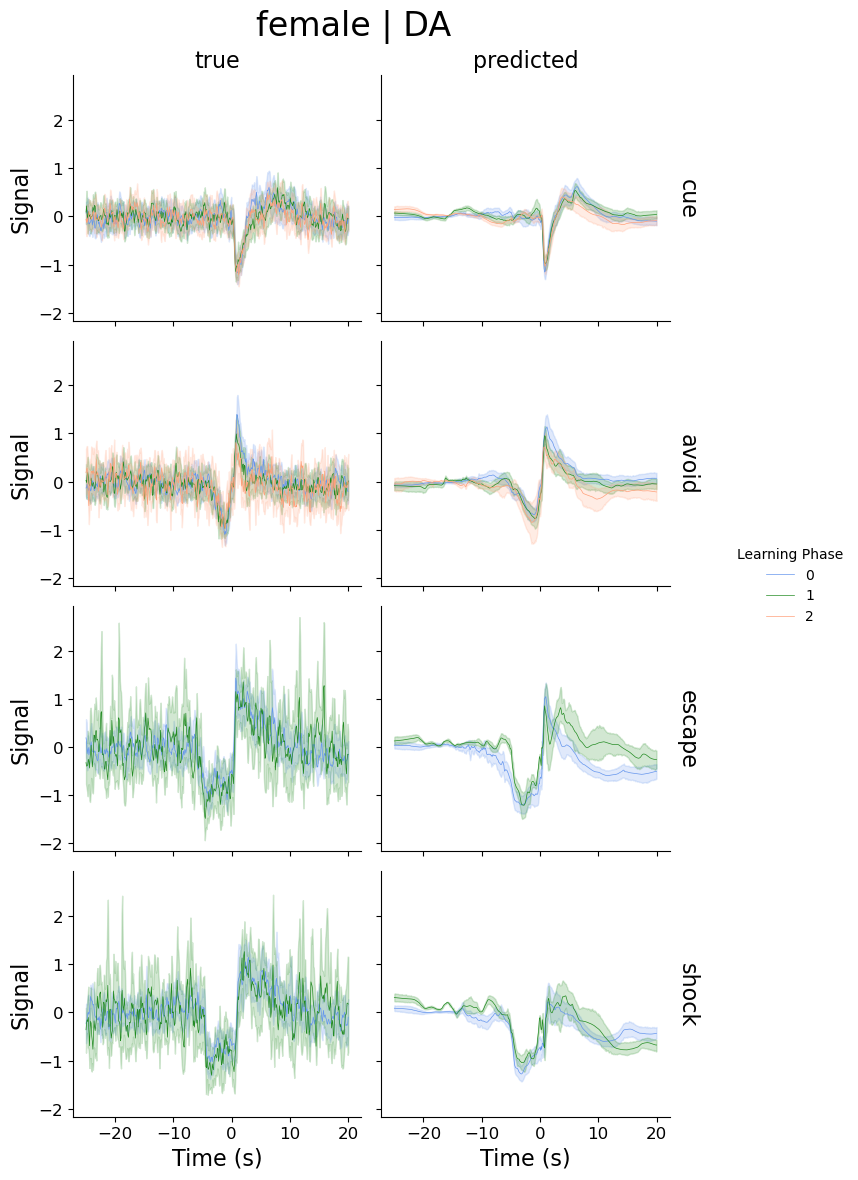

In [75]:
    
female_DA = "sensor == 'DA' & male == False"
female_DA_plot = generate_plot(con_data, female_DA, sensor='DA', sex='female')

### Male

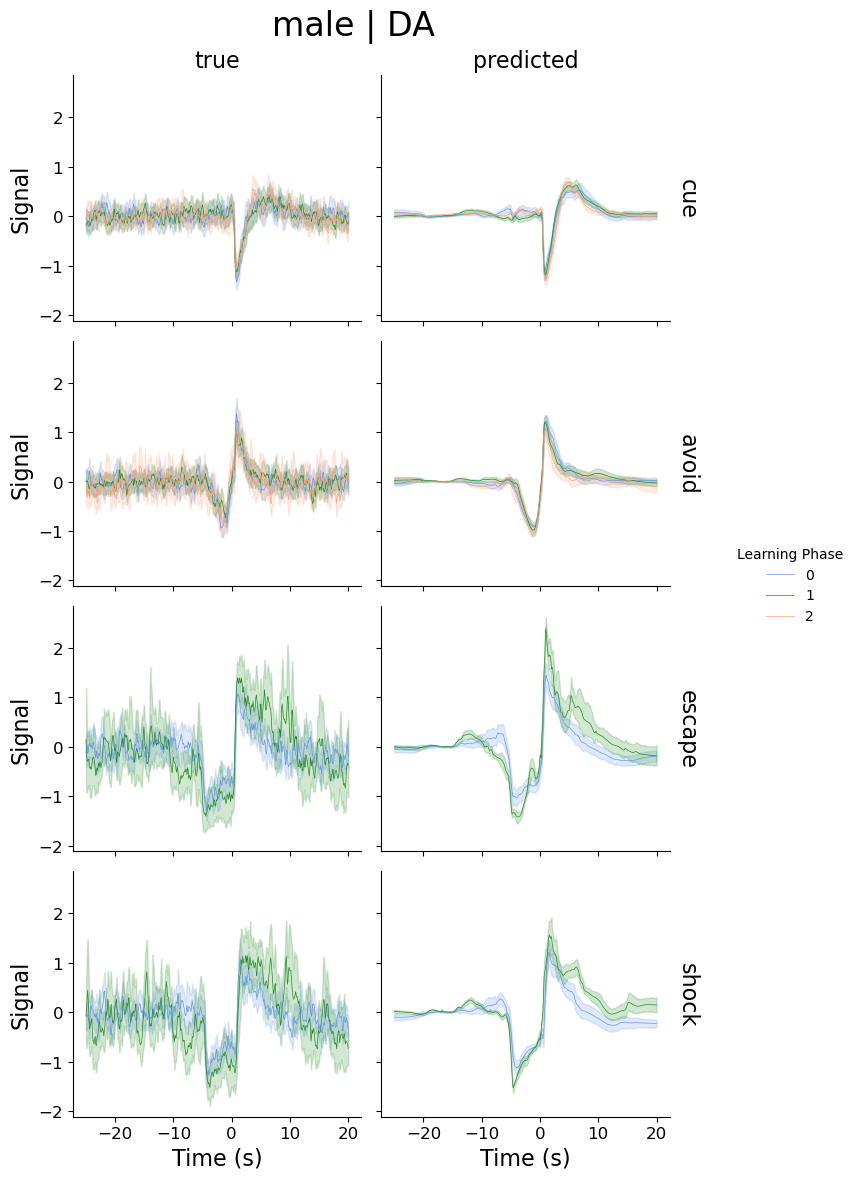

In [76]:
male_DA = "sensor == 'DA' & male == True"
male_DA_plot = generate_plot(con_data, male_DA, sensor='DA', sex='male')

## D1 (GCaMP)

### Female

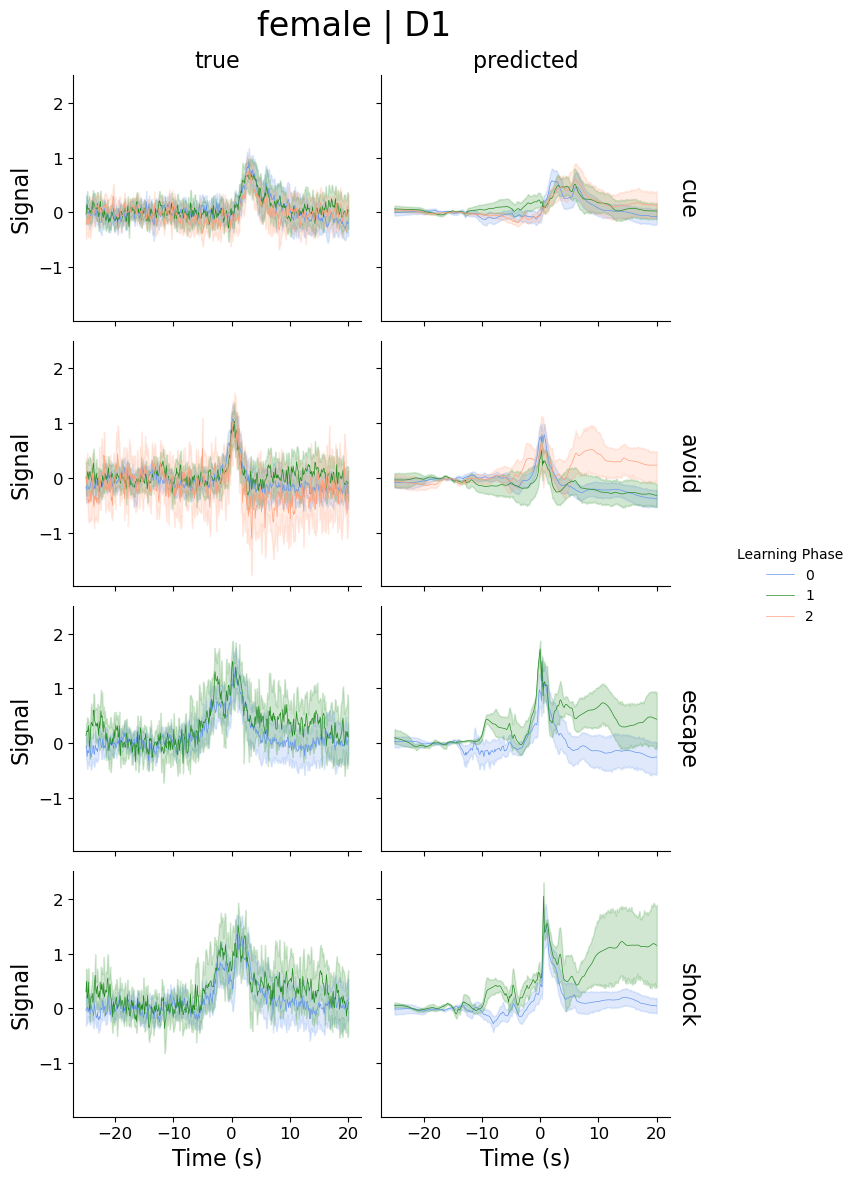

In [78]:
female_D1 = "sensor == 'D1' & male == False"  
female_D1_plot = generate_plot(con_data, female_D1, sensor = 'D1', sex = 'female')

### Male

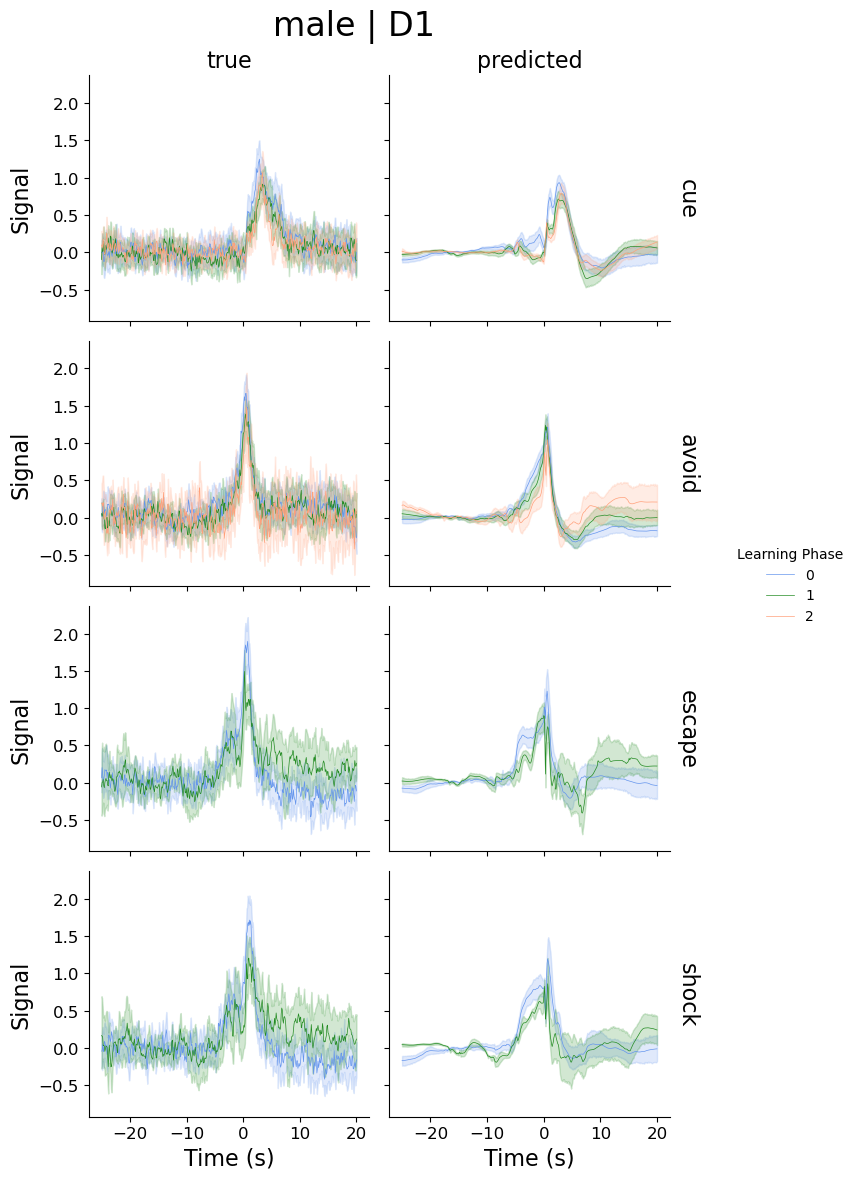

In [79]:

male_D1 = "sensor == 'D2' & male == True"
male_D1_plot = generate_plot(con_data, male_D1, sensor = 'D1', sex = 'male')

## D2(GCaMP)

### Female

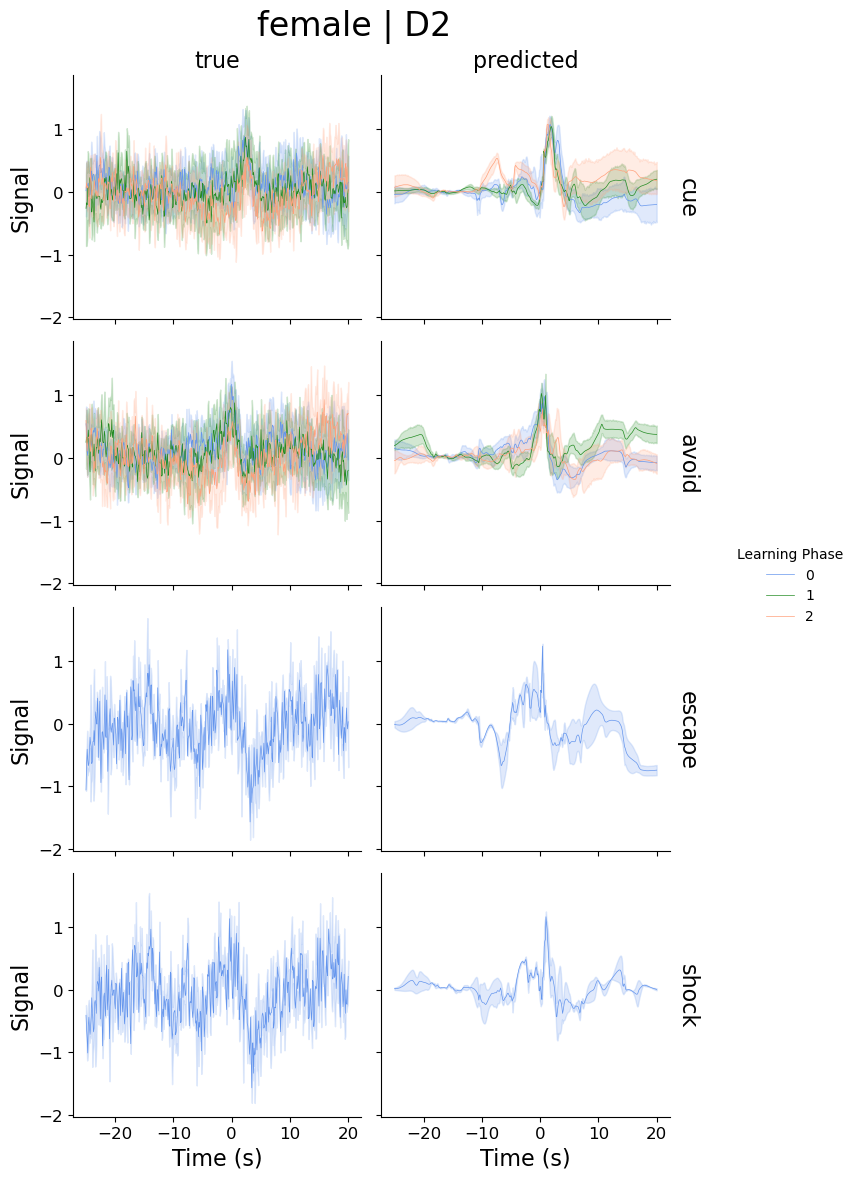

In [81]:
female_D2 = "sensor == 'D2' & male == False"
female_D2_plot = generate_plot(con_data, female_D2, sensor = 'D2', sex = 'female')

### Male

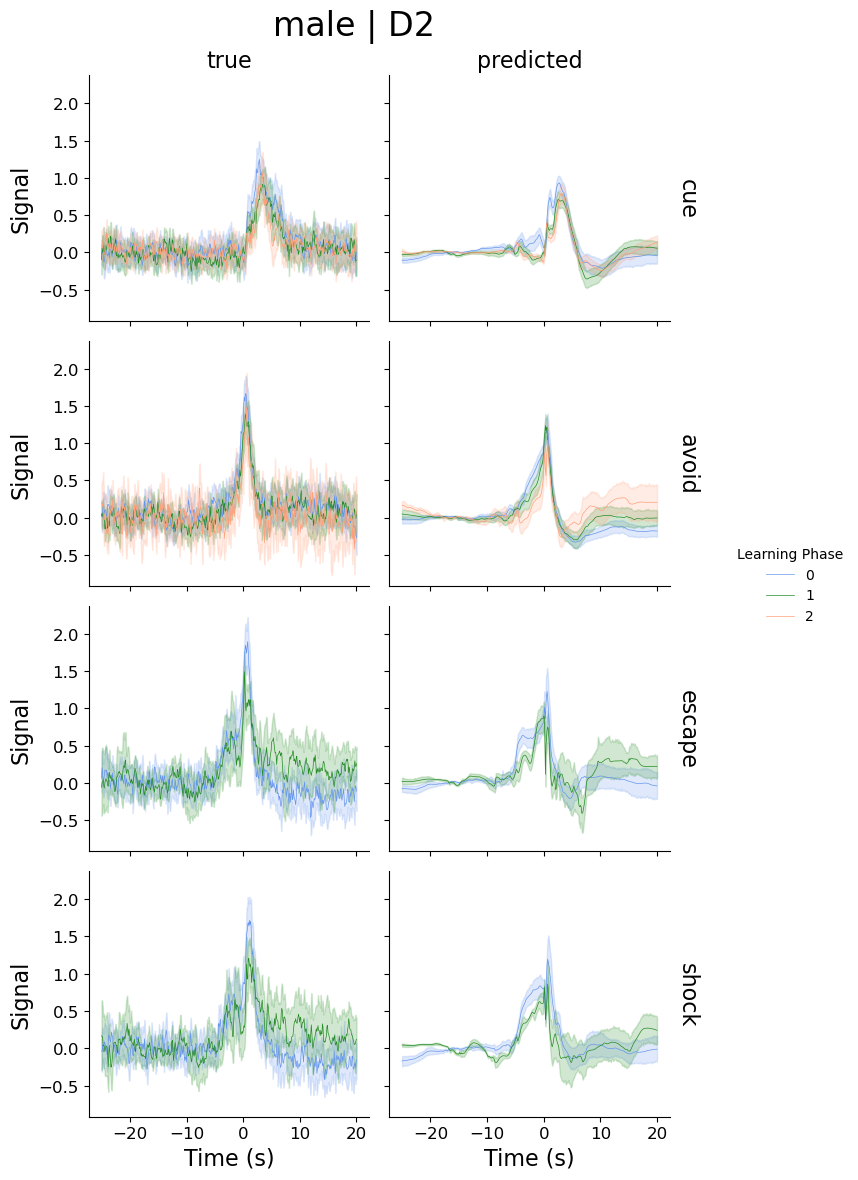

In [83]:
male_D2 = "sensor == 'D2' & male == True"
male_D2_plot = generate_plot(con_data, male_D2, sensor = 'D2', sex = 'male')

In [ ]:
no_bins_inference_data= X_test_dropped.assign(predicted_signal= y_dropped_pred,
                                              true_signal=y_test_dropped)
no_bins_inference_data.to_parquet(os.path.join(data_directory, 'no_bins_inference_data.parquet.gzip'), compression='gzip')

In [ ]:
no_bins_inference_data.head()

# Conclusions 
Predictions are far more precise with Dopamine. No idea why. 
* Female D1/D2 is far less accurate
* I think the first thing to do is to run the hyperparmater tuning experiment with the 128 units and Adam optimizer
* Add dropout layer
* THEN add Covnet layer
* Then, holdout more data (days)
* its close!


## Additional Feature engineering and analyis
Dimentionalaity reduction I think is a good start
t-SNE?
### compared to Gabys learning phase, at day 7 I dont see differences. Maybe this is an early training thing?